In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
from qiskit import transpile

algorithm_globals.random_seed = 12345
estimator = Estimator()

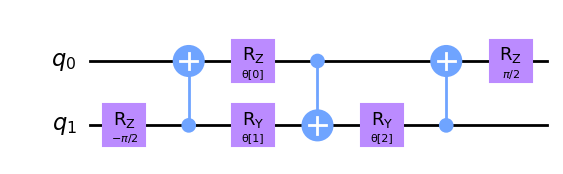

In [2]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

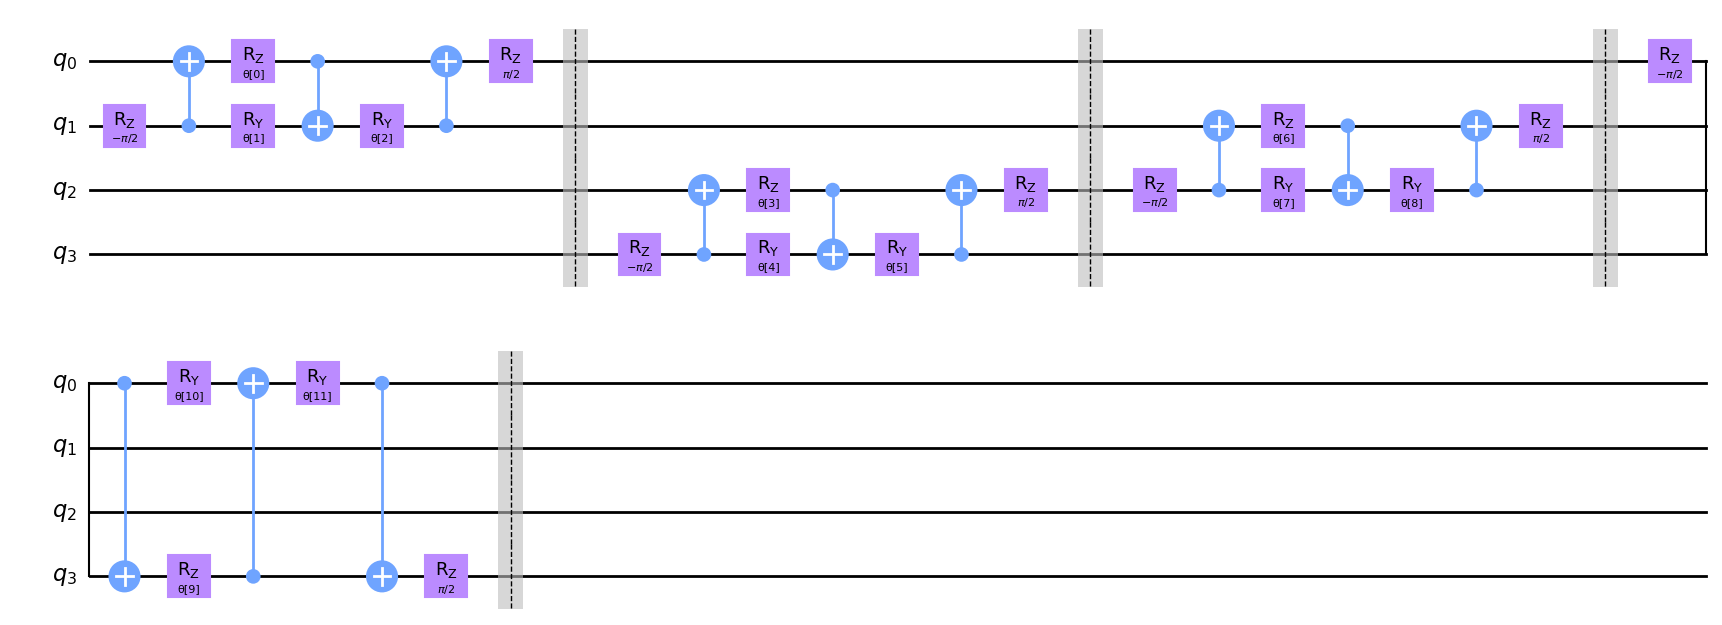

In [3]:
def conv_layer(num_qubits, param_prefix, barrier_between=True):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        if barrier_between:
            qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        if barrier_between:
            qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

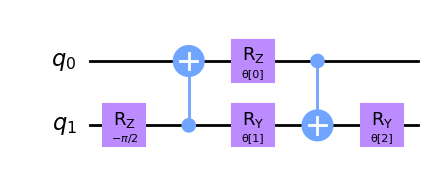

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

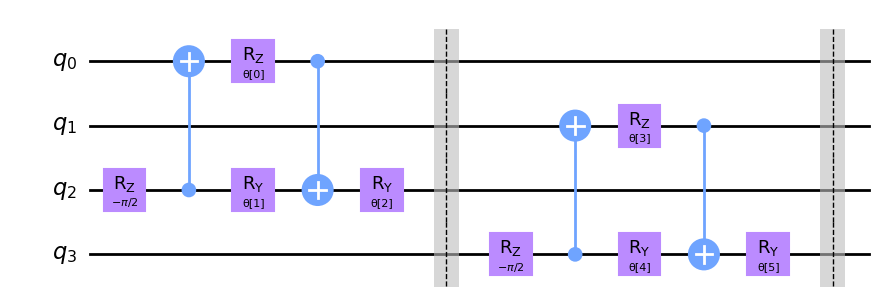

In [5]:
def pool_layer(sources, sinks, param_prefix, barrier_between=True):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        if barrier_between:
            qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [6]:
def generate_dataset(num_images_per_class=100, visualize=False):
    from tensorflow.keras.datasets import mnist
    from skimage.transform import resize
    from skimage.filters import threshold_otsu
    from skimage.exposure import rescale_intensity

    images = []
    labels = []

    (x_train, y_train), _ = mnist.load_data()
    digit_0_images = x_train[y_train == 0][:num_images_per_class]
    digit_1_images = x_train[y_train == 1][:num_images_per_class]

    def preprocess_mnist_image(image):
        image = image.astype(np.float32)
        image = rescale_intensity(image, in_range=(0, 255), out_range=(0, 1))
        resized = resize(image, (8, 8), order=3, anti_aliasing=True, mode='reflect')
        thresh = threshold_otsu(resized)
        binary = (resized > thresh).astype(int)
        return binary * (np.pi / 2)

    for img in digit_0_images:
        transformed = preprocess_mnist_image(img)
        images.append(transformed)
        labels.append(-1)
        if visualize:
            plt.imshow(transformed, cmap='gray')
            plt.title("Real MNIST 0")
            plt.colorbar()
            plt.show()

    for img in digit_1_images:
        transformed = preprocess_mnist_image(img)
        images.append(transformed)
        labels.append(1)
        if visualize:
            plt.imshow(transformed, cmap='gray')
            plt.title("Real MNIST 1")
            plt.colorbar()
            plt.show()

    return np.array(images), np.array(labels)

In [7]:
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

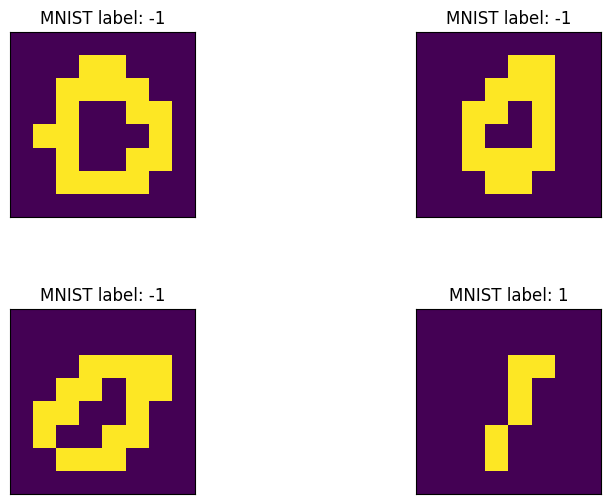

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(train_images[i].reshape(8, 8), aspect="equal")
    ax[i // 2, i % 2].set_title(f"MNIST label: {train_labels[i]}")
plt.subplots_adjust(wspace=0.1, hspace=0.5)


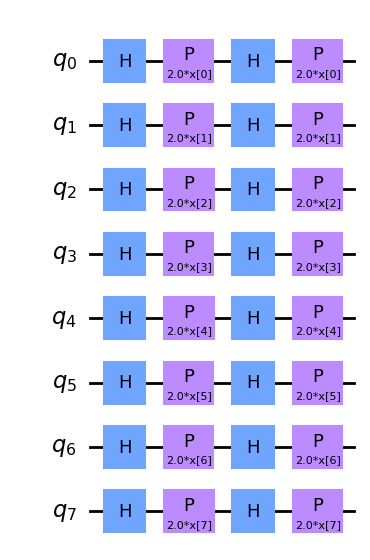

In [9]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [10]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

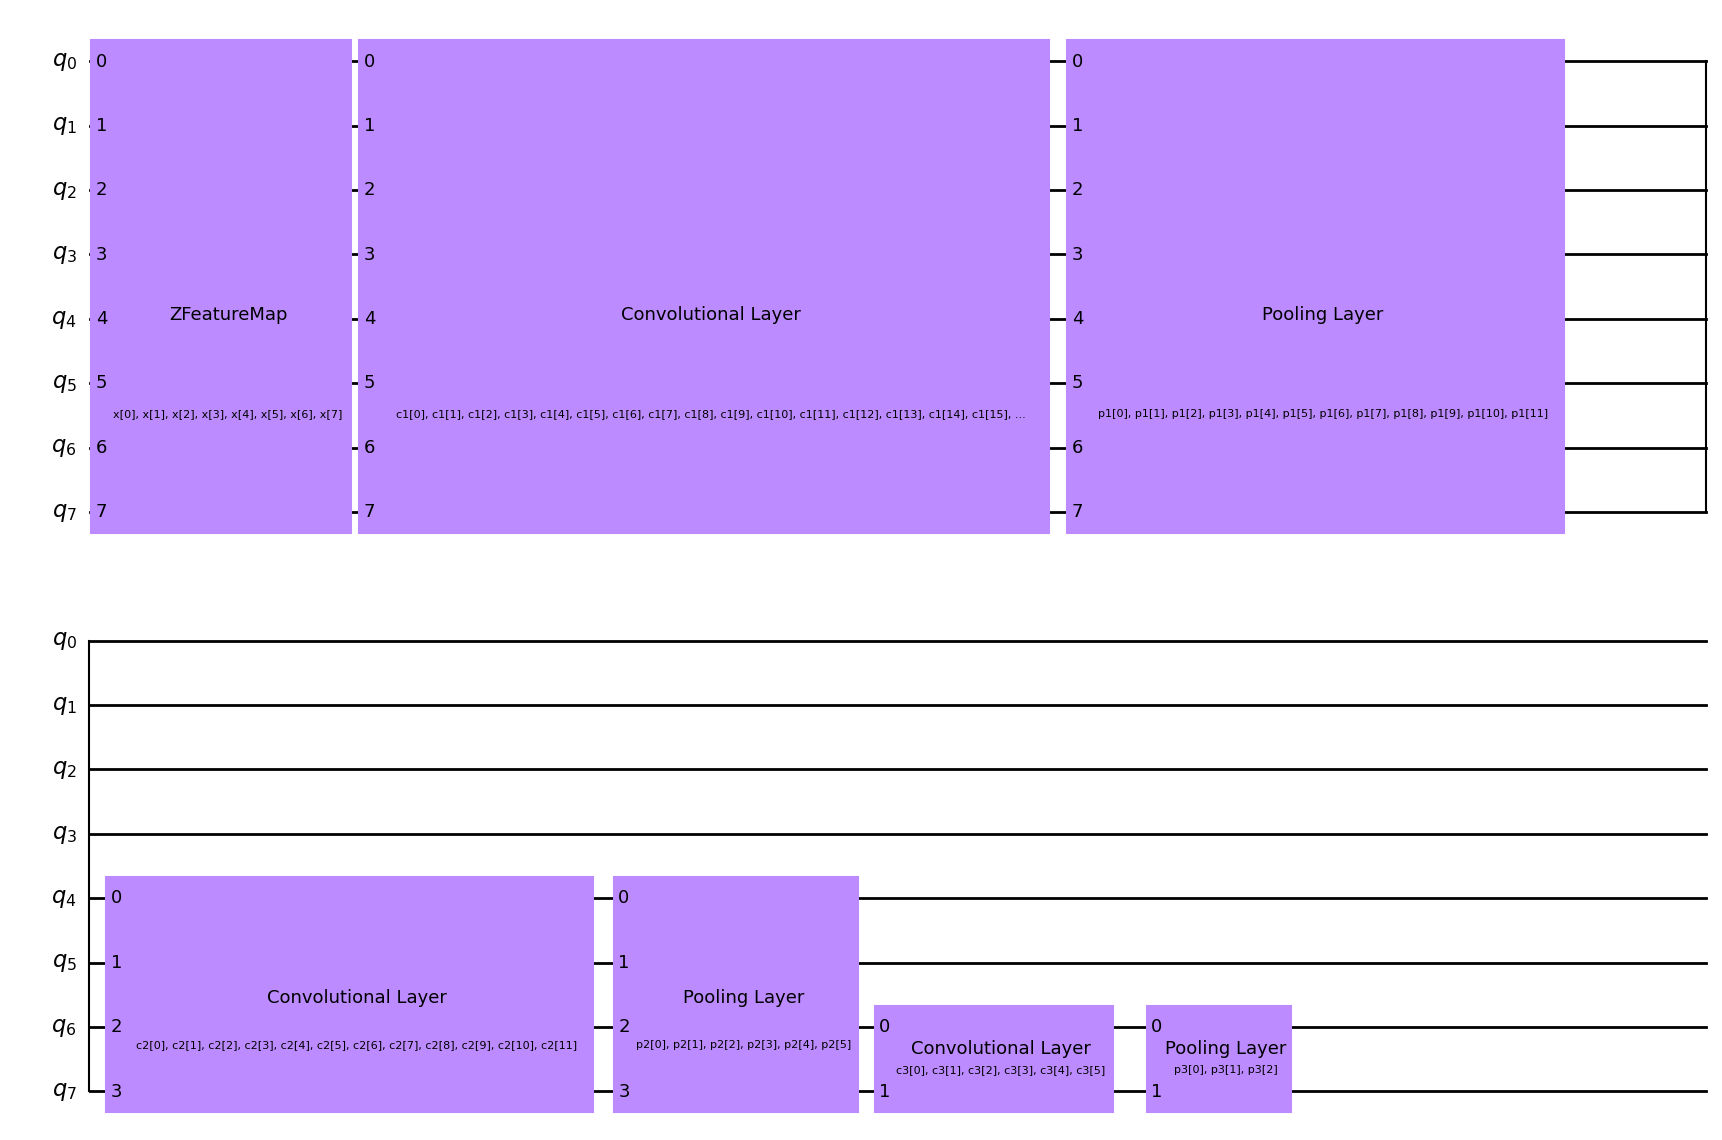

In [11]:
circuit.draw("mpl", style="clifford")

QNN circuit depth: 61
Circuit 2+ qubit depth: 24


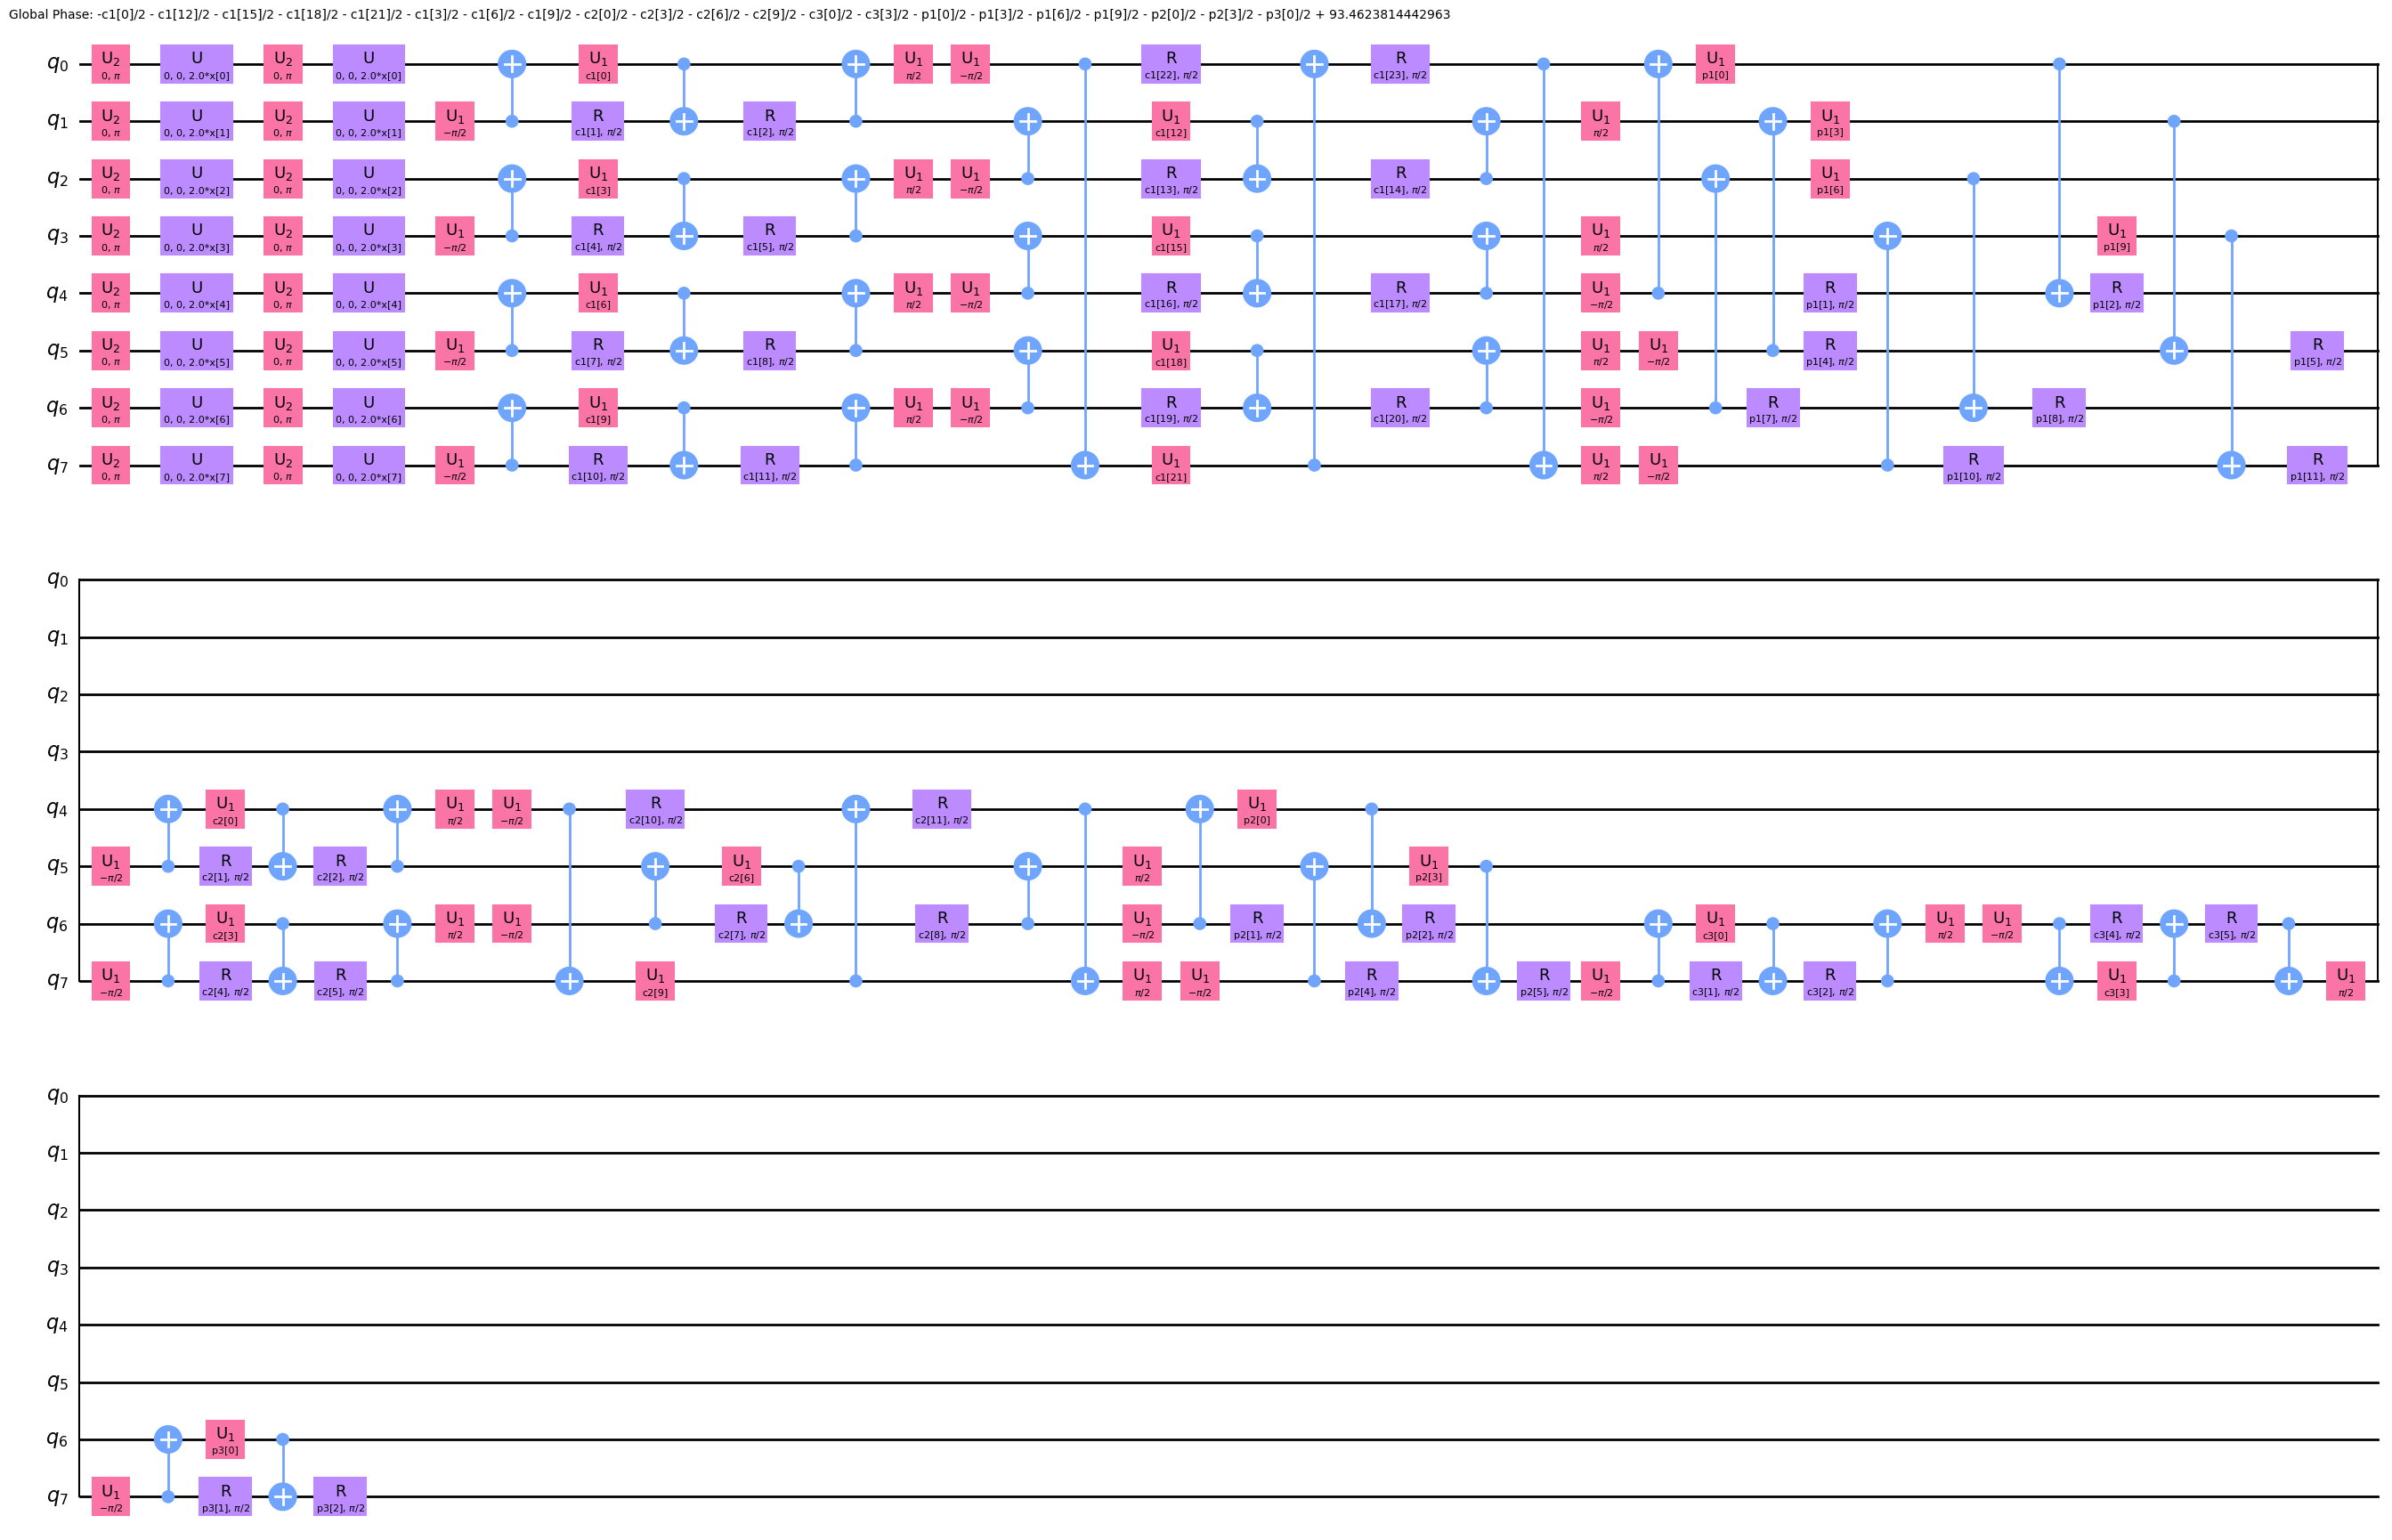

In [12]:
from qiskit.transpiler.passes import RemoveBarriers

circuit = RemoveBarriers()(qnn.circuit)
print("QNN circuit depth:", circuit.depth())
print("Circuit 2+ qubit depth:", circuit.depth(lambda instr: len(instr.qubits) > 1))
circuit.decompose().draw("mpl", style="clifford", fold=40)

In [13]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='freeya-mind-iasi/education/r2p-april2025')
backend = service.backend("ibm_sherbrooke")

fake_backend = AerSimulator.from_backend(backend)

C:\Users\tpricop\AppData\Local\Temp\ipykernel_17148\1153296116.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel='ibm_quantum',


In [14]:
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

In [15]:
ts = TranspilerService(backend_name="ibm_sherbrooke",
                       optimization_level=3,
                       ai="auto")

Transpiled circuit depth: 287
Transpiled circuit 2+ qubit depth: 59


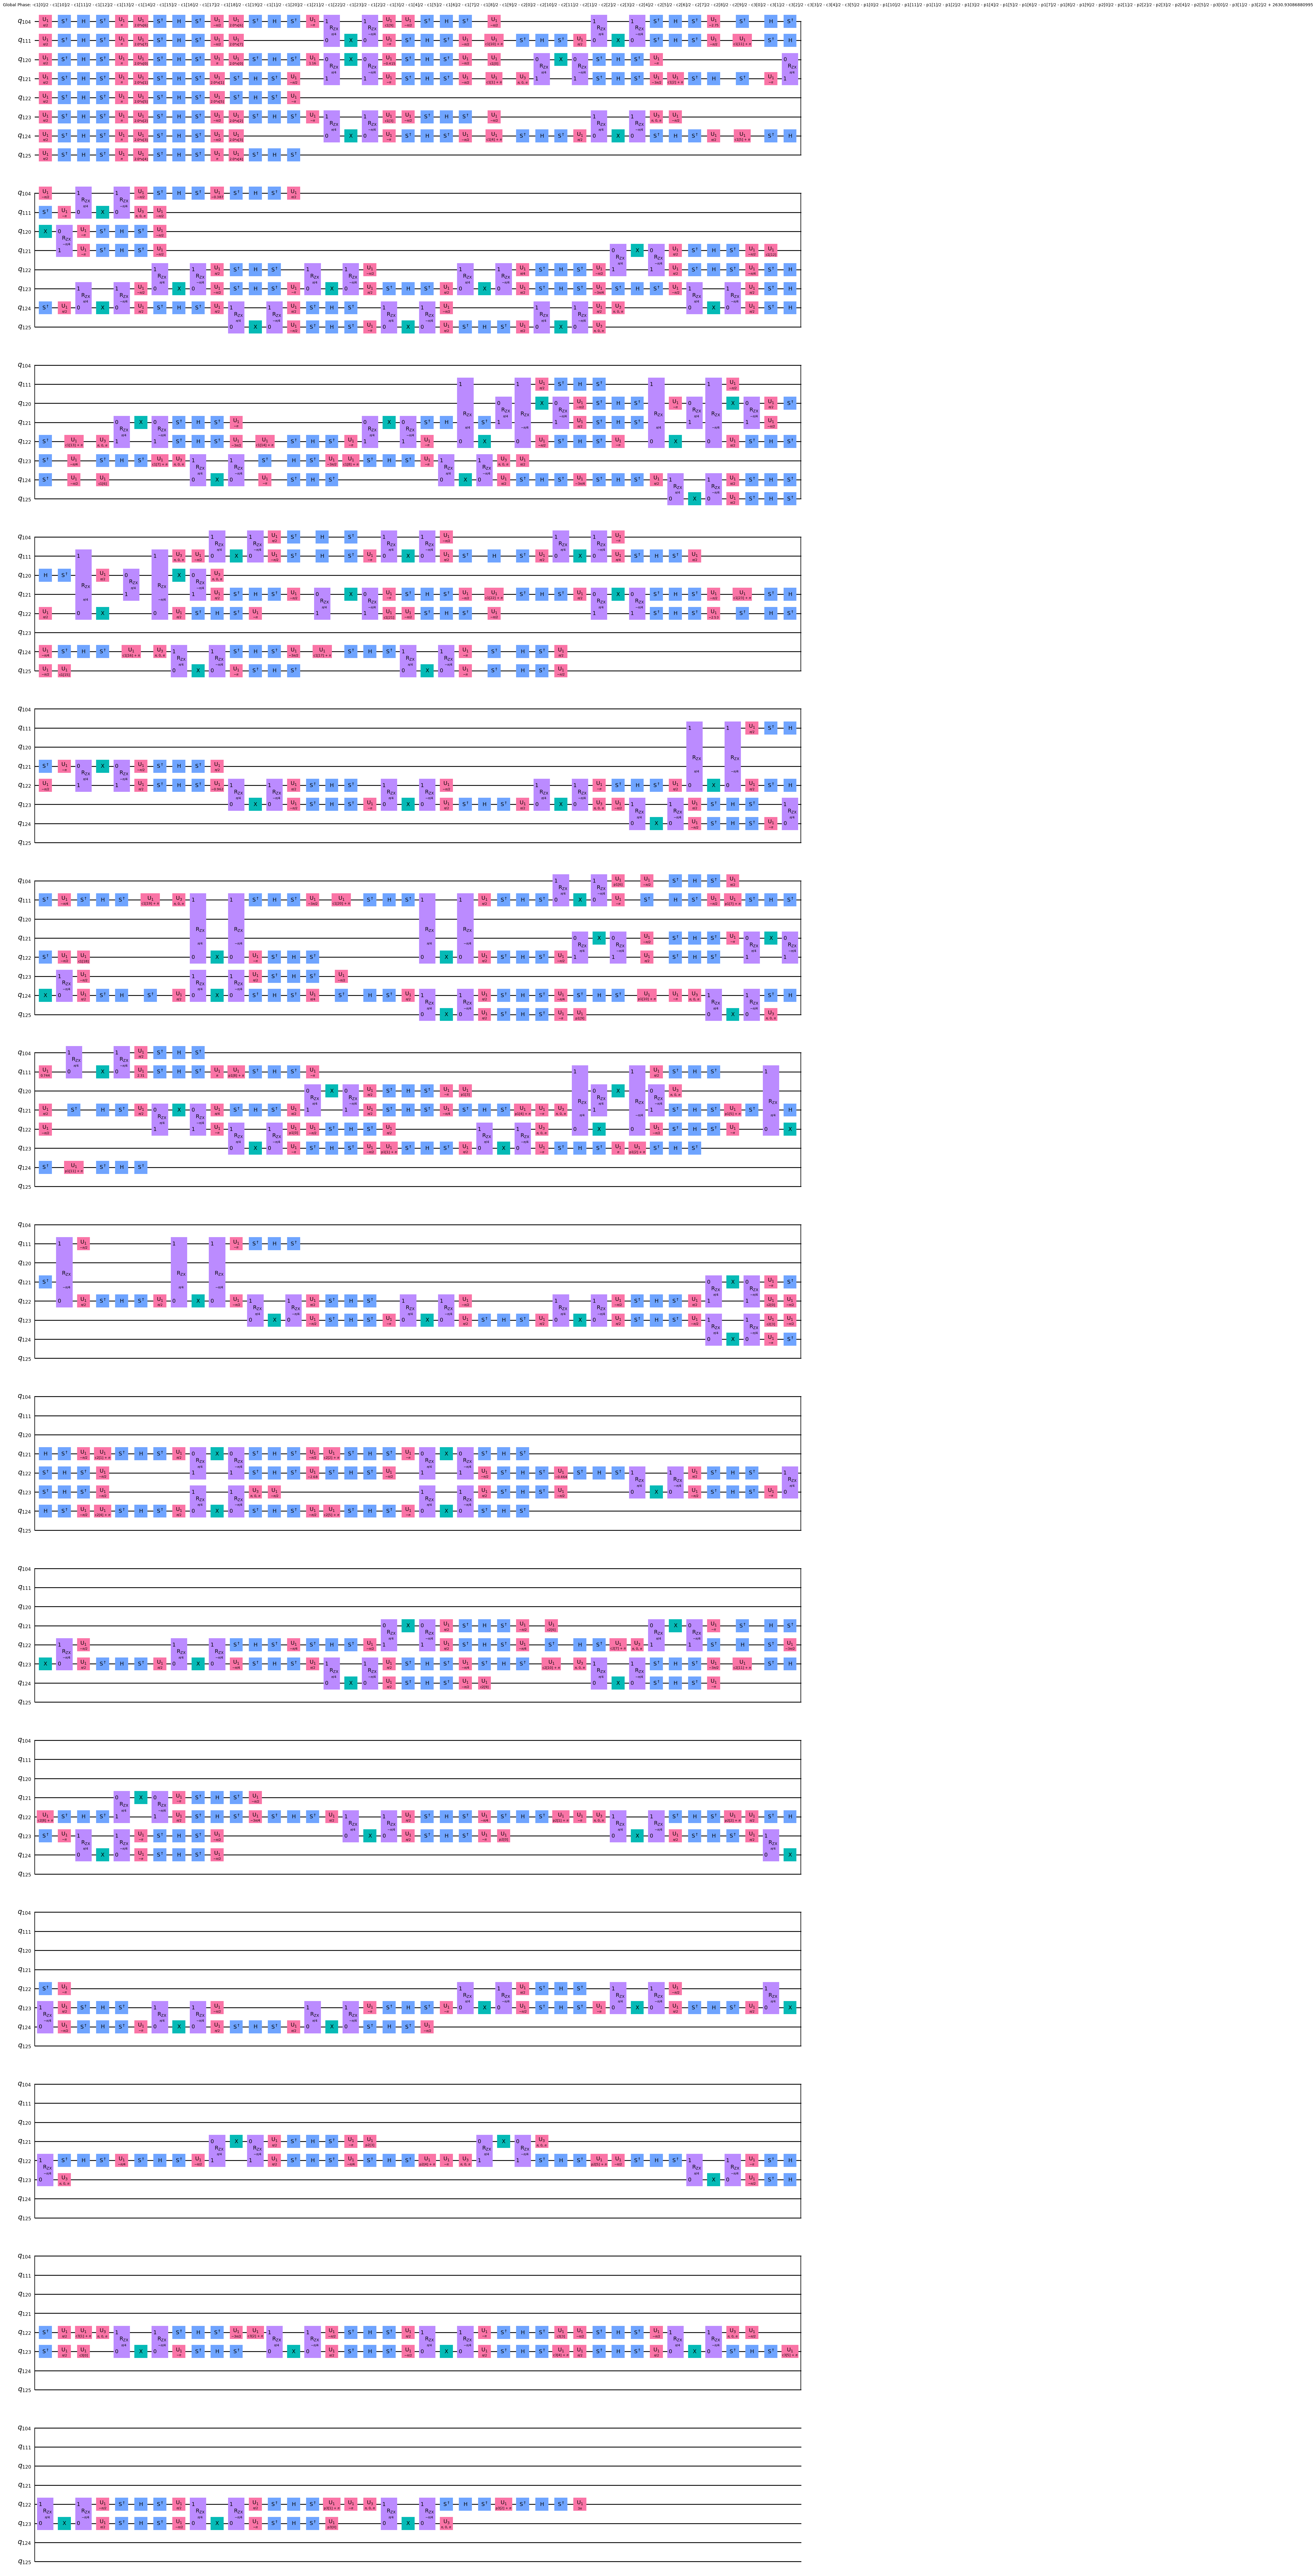

In [16]:
# Check circuit depty after transpilation
transpiled_circuit = pm.run(circuit)

print("Transpiled circuit depth:", transpiled_circuit.depth())
print("Transpiled circuit 2+ qubit depth:", transpiled_circuit.depth(lambda instr: len(instr.qubits) > 1))
transpiled_circuit.decompose().draw("mpl", idle_wires=False, style="clifford", fold=40)

In [34]:
len(transpiled_circuit.parameters)

71

In [17]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions

estimator = Estimator(
    mode = fake_backend,
    options = EstimatorOptions(default_shots=2048)       
)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
observable = observable.apply_layout(layout=transpiled_circuit.layout)

qnn = EstimatorQNN(
    circuit=transpiled_circuit,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

In [19]:
# with open("11_qcnn_initial_point.json", "r") as f:
#     initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    # initial_point=initial_point,
)

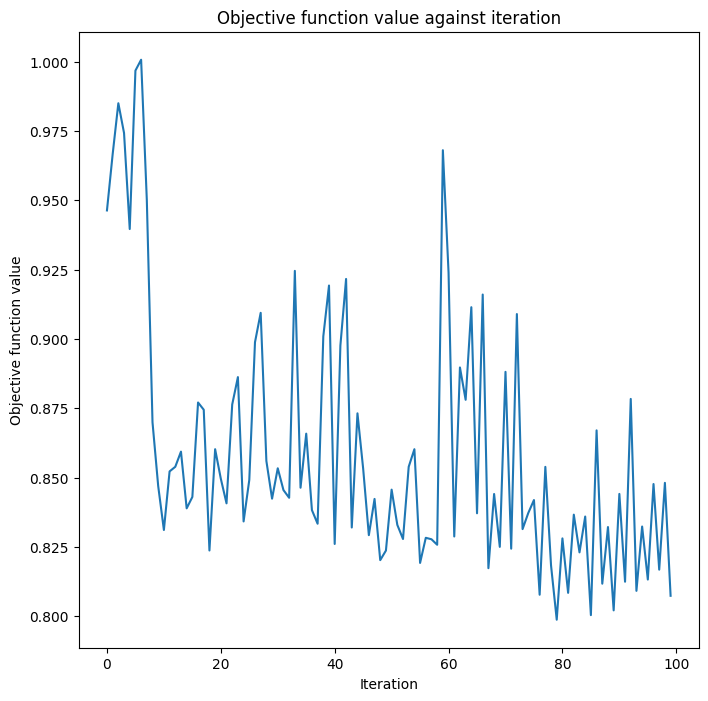

Accuracy from the train data : 76.43%


In [20]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

# Reduce each 8x8 image to a vector of length 8 by taking the mean of each row
x = x.reshape((-1, 8, 8))
x = x.mean(axis=2)  # shape: (n_samples, 8)

print(x.shape[0])

objective_func_vals = []
plt.rcParams["figure.figsize"] = (8, 8)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

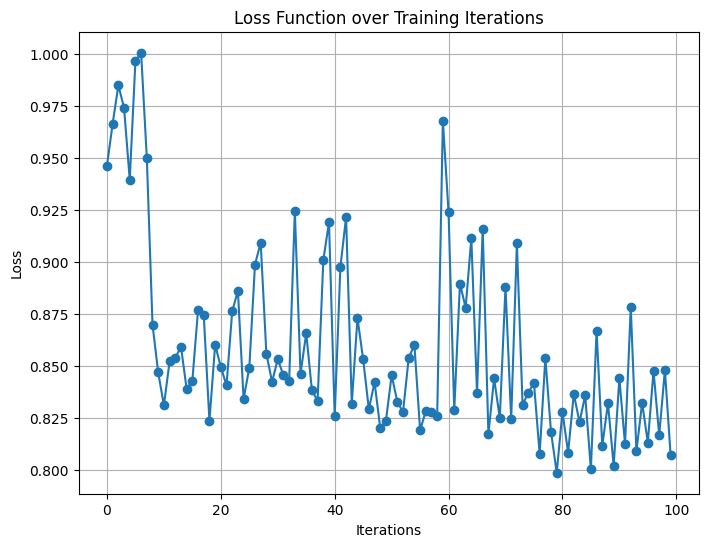

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Function over Training Iterations")
plt.grid(True)
plt.show()


Accuracy from the test data : 86.67%


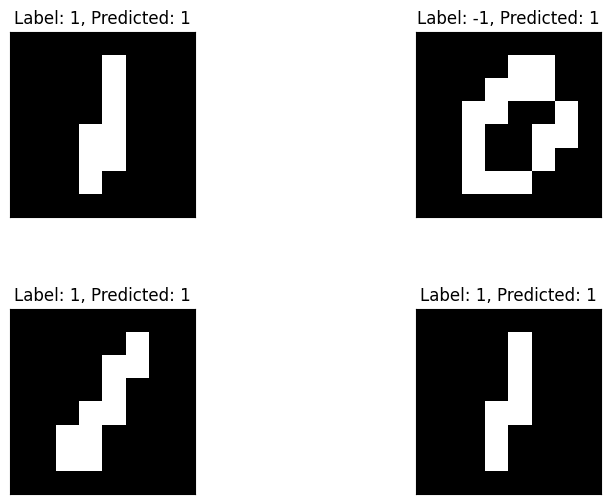

In [23]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
# Reshape test_images to match the input format used during training (mean of each row)
x_test = np.asarray(test_images).reshape((-1, 8, 8))
x_test = x_test.mean(axis=2)  # shape: (n_samples, 8)
y = np.asarray(test_labels)

# Predict using the classifier
y_predict = classifier.predict(x_test)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x_test, y), 2)}%")

# Show some examples from the MNIST test set (8x8 images)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(8, 8), cmap="gray", aspect="equal")
    ax[i // 2, i % 2].set_title(f"Label: {test_labels[i]}, Predicted: {int(y_predict[i][0])}")
plt.subplots_adjust(wspace=0.1, hspace=0.5)


In [151]:
import pickle

with open("classifier.pkl", "wb") as f:
    pickle.dump(classifier, f)
print("Model saved.")

Model saved.


In [24]:
classifier.save("qcnn_classifier.model")

---

c:\Users\tpricop\AppData\Local\anaconda3\envs\qiskit\lib\site-packages\qiskit\qpy\interface.py:346: UserWarning: The qiskit version used to generate the provided QPY file, 2.0.0, is newer than the current qiskit version 1.4.3. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


Transpiled circuit depth: 287
Transpiled circuit 2+ qubit depth: 59


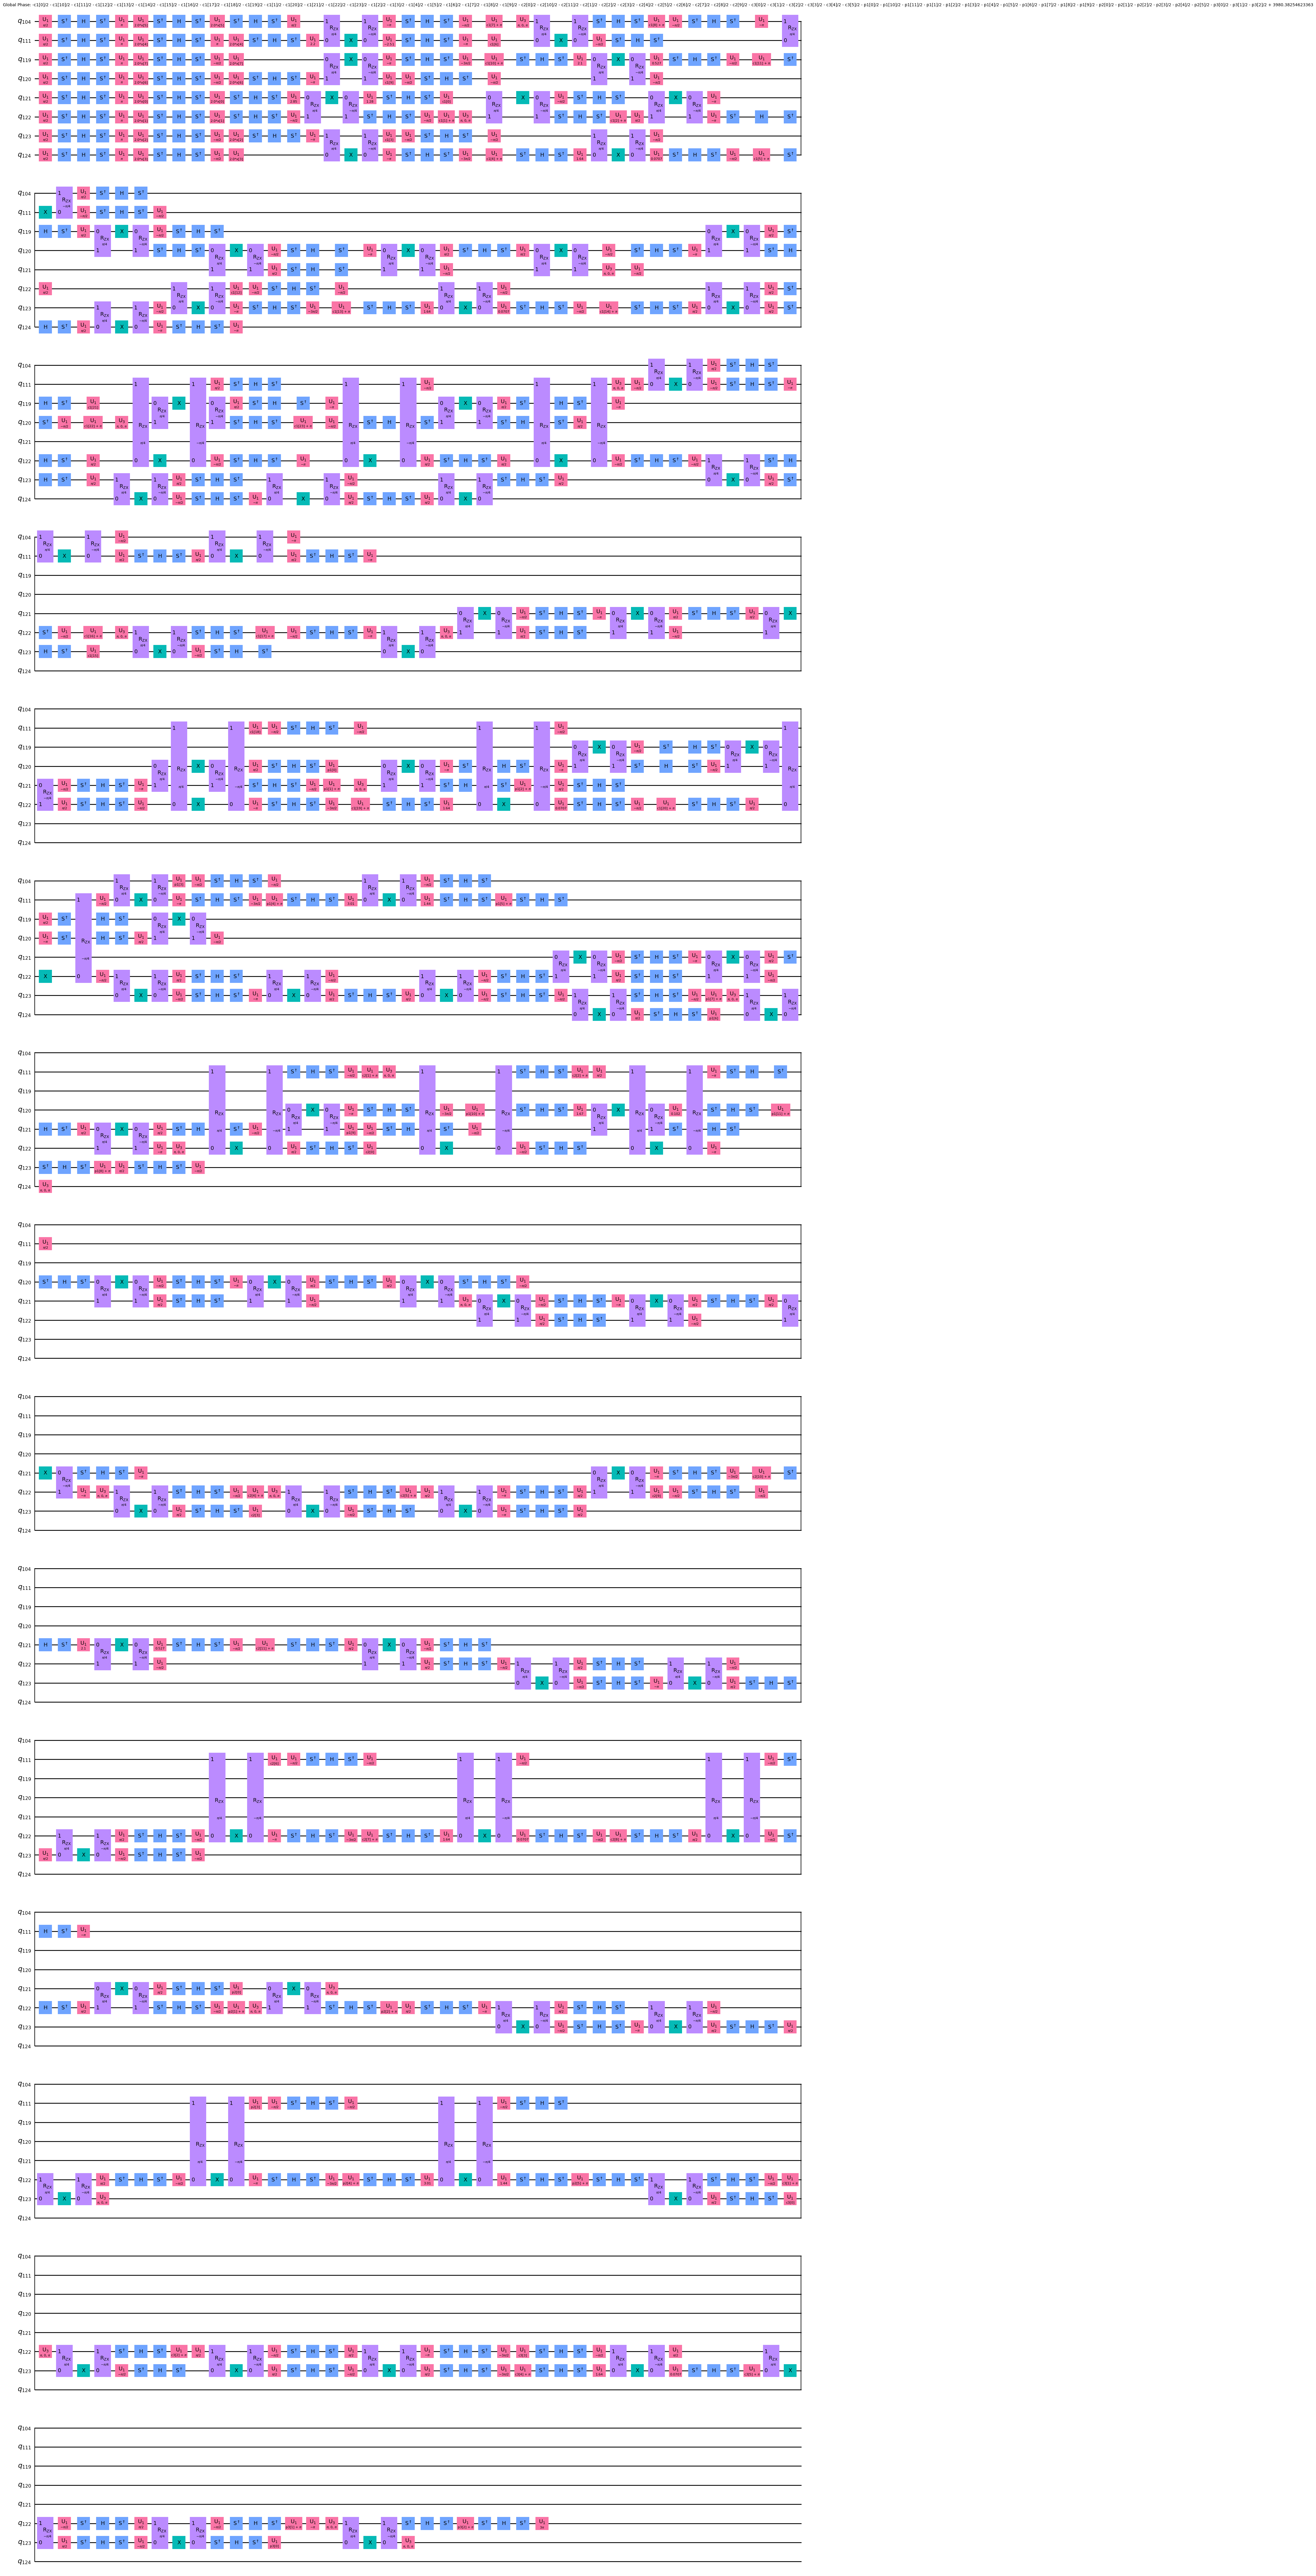

In [25]:
# Check circuit depty after transpilation
transpiled_circuit = ts.run(circuit)

print("Transpiled circuit depth:", transpiled_circuit.depth())
print("Transpiled circuit 2+ qubit depth:", transpiled_circuit.depth(lambda instr: len(instr.qubits) > 1))
transpiled_circuit.decompose().draw("mpl", idle_wires=False, style="clifford", fold=40)

In [26]:
# Test on real hardware
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions

options = EstimatorOptions(
            default_shots=2048,
            resilience_level=2, 
        )   
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XpXm'

options.resilience.zne_mitigation = True
options.resilience.zne.noise_factors = (1, 1.2, 1.5)
options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

estimator = Estimator(mode = backend, options = options)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
observable = observable.apply_layout(layout=transpiled_circuit.layout)

qnn = EstimatorQNN(
    circuit=transpiled_circuit,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

In [27]:
# this is the pretrained classifier on the fake_backend
classifier = NeuralNetworkClassifier.load("qcnn_classifier.model")
classifier.neural_network.estimator = estimator

In [28]:
classifier.save("real_qcnn_classifier.model")

In [ ]:
classifier = NeuralNetworkClassifier.load("real_qcnn_classifier.model")

In [29]:
real_test_images = test_images[4:8, :, :]
real_test_labels = test_labels[4:8]
real_test_images.shape, real_test_labels.shape

((4, 8, 8), (4,))

c:\Users\tpricop\AppData\Local\anaconda3\envs\qiskit\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Accuracy from the test data : 100.0%


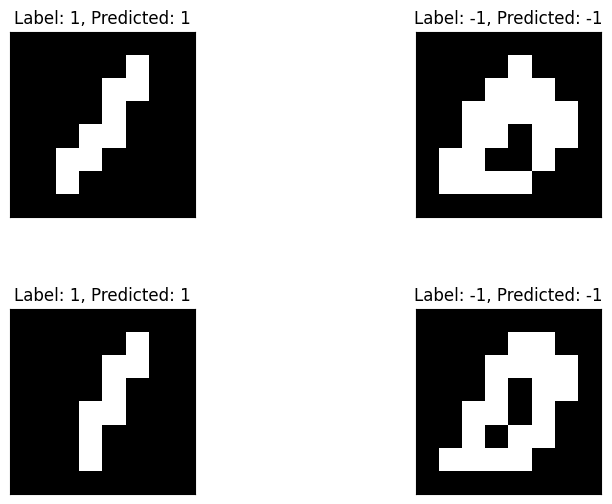

In [30]:
y_predict = classifier.predict(real_test_images)
x = np.asarray(real_test_images)
y = np.asarray(real_test_labels)
# Reshape test_images to match the input format used during training (mean of each row)
x_test = np.asarray(real_test_images).reshape((-1, 8, 8))
x_test = x_test.mean(axis=2)  # shape: (n_samples, 8)
y = np.asarray(real_test_labels)

# Predict using the classifier
y_predict = classifier.predict(x_test)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x_test, y), 2)}%")

# Show some examples from the MNIST test set (8x8 images)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(real_test_images[i].reshape(8, 8), cmap="gray", aspect="equal")
    ax[i // 2, i % 2].set_title(f"Label: {real_test_labels[i]}, Predicted: {int(y_predict[i][0])}")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

---

In [8]:
test_labels

array([ 1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,
       -1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1,
        1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1])

c:\Users\tpricop\AppData\Local\anaconda3\envs\qiskit\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


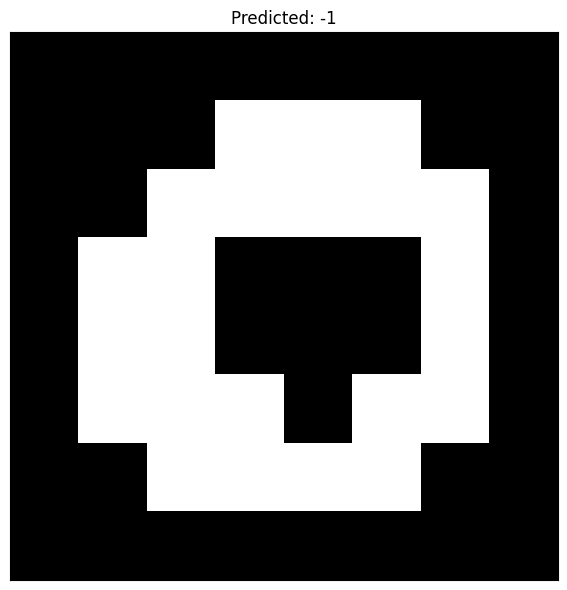

In [ ]:
# Backend for IBM Quantum Computer API
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

# Load the saved model
classifier = NeuralNetworkClassifier.load("real_qcnn_classifier.model")

# Load the image
image = test_images[-6]

# Run prediction on the image
x = np.asarray(image)
x_test = np.asarray(image).reshape((-1, 8, 8))
x_test = x_test.mean(axis=2)  # shape: (n_samples, 8)

y_predict = classifier.predict(x_test)

# Show some examples from the MNIST test set (8x8 images)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
ax.imshow(image.reshape(8, 8), cmap="gray", aspect="equal")
ax.set_title(f"Predicted: {int(y_predict[0][0])}")
plt.tight_layout()
